# Word Segmentation on Buckeye

Copyright (c) 2021 Herman Kamper, MIT License

Train a segmental autoencoding recurrent neural network (segmental AE-RNN) and perform word segmentation on encoded Buckeye.

## Preliminaries

In [2]:
from datetime import datetime
from pathlib import Path
from scipy.stats import gamma
from sklearn import cluster
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import sys
import torch
import torch.nn as nn

sys.path.append("..")

from seg_aernn import datasets, models, viterbi
from utils import eval_segmentation

## Utility functions

In [3]:
def get_segmented_sentence(ids, boundaries):
    output = ""
    cur_word = []
    for i_symbol, boundary in enumerate(boundaries):
        cur_word.append(id_to_symbol[ids[i_symbol]])
        if boundary:
            output += "_".join(cur_word)
            output += " "
            cur_word = []
    return output.strip()

In [4]:
# Duration penalty functions

# Histogram
histogram = np.array([
    0, 1.66322800e-01, 2.35838129e-01, 2.10609187e-01,
    1.48025482e-01, 9.42918160e-02, 5.84211098e-02, 3.64679480e-02,
    2.18264741e-02, 1.25420784e-02, 7.18500018e-03, 4.27118399e-03,
    1.73743077e-03, 1.19448366e-03, 7.42027726e-04, 2.89571796e-04,
    2.35277084e-04, 0.00001, 0.00001, 0.00001, 0.00001, 0.00001
    ])  # to-do: check this
histogram = histogram/np.sum(histogram)
def neg_log_hist(dur):
    return -np.log(0 if dur >= len(histogram) else histogram[dur])

# Cached Gamma
# shape, loc, scale = (2.3, 0, 1.3)  # VQ-VAE
shape, loc, scale = (2.6, 0, 1.8)    # CPC-big
# shape, loc, scale = (2.5, 0, 1.5)    # CPC-big (Gamma)
gamma_cache = []
for dur in range(200):
    gamma_cache.append(gamma.pdf(dur, shape, loc, scale))
gamma_cache = np.array(gamma_cache)/np.sum(gamma_cache)
def neg_log_gamma(dur):
    if dur < 200:
        return -np.log(gamma_cache[dur])
    else:
        return -np.log(0)
    
# Chorowski
def neg_chorowski(dur):
    return -(dur - 1)

## Data

In [50]:
# Dataset
vq_model = "gmm"
# vq_model = "cpc_big"
# vq_model = "cpc_big_normalized"
# vq_model = "xlsr"
dataset = "buckeye"
split = "val"
# seg_tag = "phoneseg_dp_penalized"
seg_tag = "phoneseg_dp_penalized_25"
# seg_tag = "phoneseg_dp_penalized_tune"

# Paths
seg_dir = (
    Path("../../vqwordseg/exp")/vq_model/dataset/split/seg_tag/"intervals"
    )
word_ref_dir = Path("../../vqwordseg/data")/dataset/"word_intervals"

In [51]:
# Read phone segmentation
phoneseg_interval_dict = {}
print("Reading: {}".format(seg_dir))
phoneseg_interval_dict = eval_segmentation.get_intervals_from_dir(seg_dir)
utterances = phoneseg_interval_dict.keys()

 11%|█         | 1755/16355 [00:00<00:00, 17547.80it/s]

Reading: ../../vqwordseg/exp/gmm/buckeye/val/phoneseg_dp_penalized_25/intervals


100%|██████████| 16355/16355 [00:00<00:00, 17663.18it/s]


In [52]:
# Read word reference
print("Reading: {}".format(word_ref_dir))
word_ref_interval_dict = eval_segmentation.get_intervals_from_dir(word_ref_dir, utterances)

 22%|██▏       | 3654/16355 [00:00<00:00, 36521.84it/s]

Reading: ../../vqwordseg/data/buckeye/word_intervals


100%|██████████| 16355/16355 [00:00<00:00, 36415.54it/s]


In [53]:
word_types = set()
for utt_key in tqdm(word_ref_interval_dict):
    for start, end, label in word_ref_interval_dict[utt_key]:
        word_types.add(label)
print("No. word types:", len(word_types))

100%|██████████| 16355/16355 [00:00<00:00, 986536.69it/s]

No. word types: 4057


In [54]:
# Convert intervals to boundaries
word_ref_boundaries_dict = {}
for utt_key in tqdm(word_ref_interval_dict):
    word_ref_boundaries_dict[utt_key] = eval_segmentation.intervals_to_boundaries(
        word_ref_interval_dict[utt_key]
        )

100%|██████████| 16355/16355 [00:00<00:00, 303241.79it/s]


In [55]:
prepared_text = []
for utt_key in tqdm(utterances):
    prepared_text.append(
        "_".join([i[2] for i in phoneseg_interval_dict[utt_key]])
        )
    
print(prepared_text[0])

100%|██████████| 16355/16355 [00:00<00:00, 457325.04it/s]

23_6_15_4_19_20_9_0_23_8_2_8_21_11_16_4_7_19_9_2_8_6_7


In [56]:
# Gold segmentation, where boundaries are inserted in best possible positions
n_not_in_tolerance = 0
prepared_text_gold = []
for utt_key in tqdm(utterances):
    seg_intervals = phoneseg_interval_dict[utt_key].copy()
    ref_intervals = word_ref_interval_dict[utt_key].copy()
    seg_boundaries = np.array([i[1] - 1 for i in seg_intervals])
    ref_boundaries = np.array([i[1] - 1 for i in ref_intervals])
    for ref_boundary in ref_boundaries[:-1]:
        i_seg = np.argmin(np.abs(seg_boundaries - ref_boundary))
        seg_intervals.insert(
            i_seg + 1, (seg_intervals[i_seg][1], seg_intervals[i_seg][1], " ")
            )
        seg_boundaries = np.array([i[1] - 1 for i in seg_intervals])
    cur_text_gold = ""
    for start, end, label in seg_intervals:
        if label == " ":
            cur_text_gold = cur_text_gold[:-1]
            cur_text_gold += " "
        else:
            cur_text_gold += label + "_"
    cur_text_gold = cur_text_gold[:-1]
    prepared_text_gold.append(cur_text_gold)

print(prepared_text_gold[0])

100%|██████████| 16355/16355 [00:00<00:00, 21659.42it/s]

23_6_15_4_19_20_9 0_23_8_2_8_21_11_16_4_7_19_9_2_8 6_7


No. word types: 45150
Mean training word length: 8.2542
Min training word length:  1
Max training word length:  50
Mean: 8.25418775393827
Gamma parameters: 2.332450230163011 0 3.5388483952180185


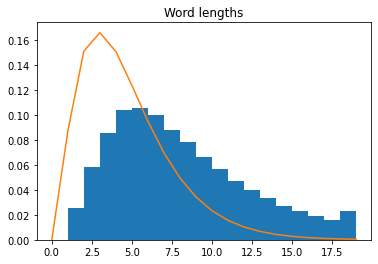

In [57]:
# Training word length statistics
word_lengths = []
n_words = []
word_types = set()
for sentence in prepared_text_gold:
    word_lengths.extend([len(i.split("_")) for i in sentence.split(" ")])
    n_words.append(len(sentence.split(" ")))
    for word in sentence.split(" "):
        word_types.add(word)
#     word_lengths.extend([len(i.replace("$", "")) for i in sentence.split(" ")])  # temp
print("No. word types:", len(word_types))
print("Mean training word length: {:.4f}".format(np.mean(word_lengths)))
print("Min training word length:  {:d}".format(np.min(word_lengths)))
print("Max training word length:  {:d}".format(np.max(word_lengths)))

# Histogram
plt.figure()
n, bins, patches = plt.hist(word_lengths, bins=range(20), density=True)
plt.title("Word lengths")

# Gamma
mean = np.mean(word_lengths)
var  = np.var(word_lengths)
alpha = (mean**2)/var
beta  = alpha / mean
shape = alpha
loc = 0
scale = 1/beta
print("Mean:", mean)
print("Gamma parameters:", shape, loc, scale)
shape, loc, scale = (2.6, 0, 1.8)
plt.plot(bins, gamma.pdf(bins, shape, loc, scale))

plt.show();

In [58]:
# Vocabulary
PAD_SYMBOL      = "<pad>"
SOS_SYMBOL      = "<s>"    # start of sentence
EOS_SYMBOL      = "</s>"   # end of sentence
BOUNDARY_SYMBOL = " "      # word boundary
symbols = set()
for sentence in prepared_text:
    for char in sentence.split("_"):
        symbols.add(char)
SYMBOLS = [PAD_SYMBOL, SOS_SYMBOL, EOS_SYMBOL, BOUNDARY_SYMBOL] + (sorted(list(symbols)))
symbol_to_id = {s: i for i, s in enumerate(SYMBOLS)}
id_to_symbol = {i: s for i, s in enumerate(SYMBOLS)}

def text_to_id(text, add_sos_eos=False):
    """
    Convert text to a list of symbol IDs.

    Sentence start and end symbols can be added by setting `add_sos_eos`.
    """
    symbol_ids = []
    for word in text.split(" "):
        for code in word.split("_"):
            symbol_ids.append(symbol_to_id[code])
        symbol_ids.append(symbol_to_id[BOUNDARY_SYMBOL])
    symbol_ids = symbol_ids[:-1]  # remove last space

    if add_sos_eos:
        return [symbol_to_id[SOS_SYMBOL]] + symbol_ids + [symbol_to_id[EOS_SYMBOL]]
    else:
        return symbol_ids

print(text_to_id(prepared_text[0]))
print([id_to_symbol[i] for i in text_to_id(prepared_text[0])])

[20, 25, 11, 23, 15, 17, 28, 4, 20, 27, 16, 27, 18, 7, 12, 23, 26, 15, 28, 16, 27, 25, 26]
['23', '6', '15', '4', '19', '20', '9', '0', '23', '8', '2', '8', '21', '11', '16', '4', '7', '19', '9', '2', '8', '6', '7']


In [59]:
# First three words of training data
word_dataset = datasets.WordDataset(prepared_text, text_to_id)
for i in range(7):
    sample = word_dataset[i]
    print("_".join([id_to_symbol[i] for i in sample.numpy()]))

23_6_15_4_19_20_9_0_23_8_2_8_21_11_16_4_7_19_9_2_8_6_7
12_14_24_18_1_10_17_22_15_12_2
5_15_3_13_22_15_2_4_3_1_13_14_5_22_1_17_22_15_12_4_5_3_1_13_17_22_15_2_21_4_5_0_20_5_21_17_11
23_17_22_15_2_11_3_7_4_7_0_8_5_6_7_22_0_5_15_6_2_4
23_6_7_19_8_22_1_7_19_9_8_2_6_3_7_19_9_8_1_7_19_9_0_8_9_3_10_5_20_8_17_22_15_2_7_16_9_8_1_7
23_6_4_3_5_17_6_15_18_12_7_5_0_24_19_9_8_6_3_7_19_9
23_24_6_11_18_12_19_9_10_0_24_8_6_2_4_7_4_10_0_24_21_1_21_2_11_3_13_14_17_22_15_4_19_0_24_9_3_24_18_24_1_18_15_12_19_20_9_20_0_24_9_10


In [60]:
# Data

# Approximate ground truth (for debugging)
# cur_train_sentences = prepared_text_gold[:10000]
cur_val_sentences = prepared_text_gold[-1000:]

# No boundaries
# cur_train_sentences = prepared_text[:10000]
cur_train_sentences = prepared_text

# Random boundaries
np.random.seed(42)
# cur_train_sentences = insert_random_boundaries(cur_train_sentences)
# cur_val_sentences = insert_random_boundaries(cur_val_sentences)

print("No. train sentences:", len(cur_train_sentences))
print("Examples:", cur_train_sentences[:3])
print("Min length: ", min([len(i.split("_")) for i in cur_train_sentences]))
print("Max length: ", max([len(i.split("_")) for i in cur_train_sentences]))
print("Mean length: {:.4f}".format(np.mean([len(i.split("_")) for i in cur_train_sentences])))

No. train sentences: 16355
Examples: ['23_6_15_4_19_20_9_0_23_8_2_8_21_11_16_4_7_19_9_2_8_6_7', '12_14_24_18_1_10_17_22_15_12_2', '5_15_3_13_22_15_2_4_3_1_13_14_5_22_1_17_22_15_12_4_5_3_1_13_17_22_15_2_21_4_5_0_20_5_21_17_11']
Min length:  1
Max length:  247
Mean length: 28.3211


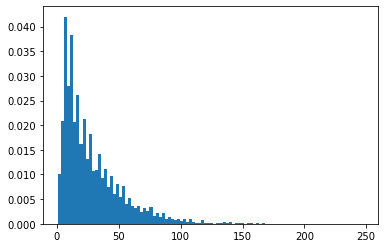

In [61]:
plt.hist([len(i.split("_")) for i in cur_train_sentences], 100, density=True)
plt.show()

## Model

In [62]:
# AE-RNN model
n_symbols = len(SYMBOLS)
symbol_embedding_dim = 10  # 25
hidden_dim = 500  # 250  # 500  # 1000  # 200
embedding_dim = 50  # 150  # 300  # 25
teacher_forcing_ratio = 0.5  # 1.0  # 0.5  # 1.0
n_encoder_layers = 1  # 1  # 3  # 10
n_decoder_layers = 1  # 1  # 1
batch_size = 32  # 32*3  # 32
learning_rate = 0.001
input_dropout = 0.0  # 0.0 # 0.5
dropout = 0.0
n_symbols_max = 50  # 25
# n_epochs_max = 5
n_epochs_max = None  # determined from n_max_steps and batch size
n_steps_max = 1500  # 2500  # 1500  # 1000  # None
# n_steps_max = None  # Only use n_epochs_max
bidirectional_encoder = False  # False

encoder = models.Encoder(
    n_symbols=n_symbols,
    symbol_embedding_dim=symbol_embedding_dim,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_encoder_layers,
    dropout=dropout,
    input_dropout=input_dropout,
    bidirectional=bidirectional_encoder
    )
# decoder = models.Decoder1(
#     n_symbols=n_symbols,
#     symbol_embedding_dim=symbol_embedding_dim,
#     hidden_dim=hidden_dim,
#     embedding_dim=embedding_dim,
#     n_layers=n_decoder_layers,
#     sos_id = symbol_to_id[SOS_SYMBOL],
#     teacher_forcing_ratio=teacher_forcing_ratio,
#     dropout=dropout
#     )
decoder = models.Decoder2(
    n_symbols=n_symbols,
    hidden_dim=hidden_dim,
    embedding_dim=embedding_dim,
    n_layers=n_decoder_layers,
    dropout=dropout
    )
model = models.EncoderDecoder(encoder, decoder)

## Pre-training

In [63]:
# Training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Training data
train_dataset = datasets.WordDataset(
    cur_train_sentences, text_to_id, n_symbols_max=n_symbols_max
    )
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Validation data
val_dataset = datasets.WordDataset(cur_val_sentences, text_to_id)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=datasets.pad_collate
    )

# Loss
criterion = nn.NLLLoss(
    reduction="sum", ignore_index=symbol_to_id[PAD_SYMBOL]
    )
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

if n_epochs_max is None:
    steps_per_epoch = np.ceil(len(cur_train_sentences)/batch_size)
    n_epochs_max = int(np.ceil(n_steps_max/steps_per_epoch))

i_step = 0
for i_epoch in range(n_epochs_max):

    # Training
    model.train()
    train_losses = []
    for i_batch, (data, data_lengths) in enumerate(tqdm(train_loader)):
        optimiser.zero_grad()
        data = data.to(device)       
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        loss = criterion(
            decoder_output.contiguous().view(-1, decoder_output.size(-1)),
            data.contiguous().view(-1)
            )
        loss /= len(data_lengths)
        loss.backward()
        optimiser.step()
        train_losses.append(loss.item())
        i_step += 1
        if i_step == n_steps_max and n_steps_max is not None:
            break

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for i_batch, (data, data_lengths) in enumerate(val_loader):
            data = data.to(device)            
            encoder_embedding, decoder_output = model(
                data, data_lengths, data, data_lengths
                )

            loss = criterion(
                decoder_output.contiguous().view(-1,
                decoder_output.size(-1)), data.contiguous().view(-1)
                )
            loss /= len(data_lengths)
            val_losses.append(loss.item())
    
    print(
        "Epoch {}, train loss: {:.3f}, val loss: {:.3f}".format(
        i_epoch,
        np.mean(train_losses),
        np.mean(val_losses))
        )
    sys.stdout.flush()

    if i_step == n_steps_max and n_steps_max is not None:
        break

100%|██████████| 512/512 [00:16<00:00, 30.81it/s]


Epoch 0, train loss: 72.231, val loss: 18.651


100%|██████████| 512/512 [00:16<00:00, 31.33it/s]


Epoch 1, train loss: 63.552, val loss: 13.996


 93%|█████████▎| 475/512 [00:15<00:01, 31.32it/s]


Epoch 2, train loss: 58.771, val loss: 11.885


In [64]:
# Examples without segmentation

# Apply to validation data
model.eval()
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(val_loader):
        data = data.to(device)
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )
        
        y, log_probs = model.decoder.greedy_decode(
            encoder_embedding,
            max_length=25,
            )
        x = data.cpu().numpy()
        
        for i_input in range(y.shape[0]):
            # Only print up to EOS symbol
            input_symbols = []
            for i in x[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                input_symbols.append(id_to_symbol[i])
            output_symbols = []
            for i in y[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                output_symbols.append(id_to_symbol[i])

            print("Input: ", "_".join(input_symbols))
            print("Output:", "_".join(output_symbols))
            print()
            
            if i_input == 10:
                break
        
        break

Input:  11_3_7_10_5_19_20
Output: 11_3_3_10_5_19_19_20_20_20_20_10_10_10_10_10_10_10_10_10_10_10_10_10_10

Input:  23_6_15_12_4_19_20_23
Output: 23_6_15_12_4_19_20_23_23_23_23_23_23_23_23_23_23_23_23_23_23_23_23_23_23

Input:  0_11_18_24_18_11_24_11_18_7_10_19_8_12_6_5
Output: 18_18_11_11_11_18_18_18_12_7_19_20_8_6_6_11_18_10_10_10_5_5_5_10_10

Input:  17_22_11_18
Output: 17_22_11_18_18_18_18_18_18_18_18_18_18_18_18_18_18_18_18_18_18_18_18_18_18

Input:  5_0_11_3_1_14_17
Output: 0_0_11_3_1_14_17_17_17_14_10_10_10_10_14_14_14_14_14_14_14_14_14_14_14

Input:  22_15_12
Output: 22_22_12_12_12_12_10_10_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12_12

Input:  10_0_17_22_12_2_7_10_0
Output: 0_17_17_15_12_2_4_10_0_10_10_10_10_10_10_10_10_10_10_10_10_10_10_10_10

Input:  11_16_4_5_0
Output: 11_11_4_5_0_0_0_5_5_5_5_10_10_10_10_10_10_5_5_5_10_10_10_10_10

Input:  9_8_6_4
Output: 8_8_6_4_4_10_10_10_10_10_10_10_10_10_10_10_10_10_10_10_10_10_10_10_10

Input:  17_22_12_7_4_19_9_20_9_8_21_6_21
Outp

## Segmentation

In [65]:
# Utterances for evaluation
n_eval_utterances = len(prepared_text)  # 1000  # 10000  # 1000
# eval_sentences = prepared_text[-n_eval_utterances:]  # val sentences
# eval_utterances = list(utterances)[-n_eval_utterances:]
eval_sentences = prepared_text[:n_eval_utterances]
eval_utterances = list(utterances)[:n_eval_utterances]

In [66]:
# Embed segments

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Data
sentences = eval_sentences
# sentences = cur_val_sentences
interval_dataset = datasets.SentenceIntervalDataset(
    sentences,
    text_to_id,
    join_char="_"
    )
segment_loader = DataLoader(
    interval_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=datasets.pad_collate,
    drop_last=False
    )

# Apply model to data
model.decoder.teacher_forcing_ratio = 1.0
model.eval()
rnn_losses = []
lengths = []
eos = []
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(tqdm(segment_loader)):
        data = data.to(device)
        
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        for i_item in range(data.shape[0]):
            item_loss = criterion(
                decoder_output[i_item].contiguous().view(-1,
                decoder_output[i_item].size(-1)),
                data[i_item].contiguous().view(-1)
                )
            rnn_losses.append(item_loss.cpu().numpy())
            lengths.append(data_lengths[i_item])

100%|██████████| 167767/167767 [13:57<00:00, 200.34it/s]


In [77]:
# Segment

dur_weight = 10.0

i_item = 0
losses = []
cur_segmented_sentences = []
for i_sentence, intervals in enumerate(tqdm(interval_dataset.intervals)):
    
    # Costs for segment intervals
    costs = np.inf*np.ones(len(intervals))
    i_eos = intervals[-1][-1]
    for i_seg, interval in enumerate(intervals):
        if interval is None:
            continue
        i_start, i_end = interval
        dur = i_end - i_start
        assert dur == lengths[i_item]
        eos = (i_end == i_eos)  # end-of-sequence
        
        # Chorowski
        costs[i_seg] = (
            rnn_losses[i_item]
            + dur_weight*neg_chorowski(dur)
            )
        
#         # Gamma
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + dur_weight*neg_log_gamma(dur)
#             + np.log(np.sum(gamma_cache**dur_weight))
#             )
        
#         # Poisson
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + neg_log_poisson(dur)
#             )

#         # Histogram
#         costs[i_seg] = (
#             rnn_losses[i_item]
#             + dur_weight*(neg_log_hist(dur))
#             + np.log(np.sum(histogram**dur_weight))
#             )
    
#         # Sequence boundary
#         alpha = 0.3  # 0.3  # 0.9
#         if eos:
#             costs[i_seg] += -np.log(alpha)
#         else:
#             costs[i_seg] += -np.log(1 - alpha)
# #             K = 5000
# #             costs[i_seg] += -np.log((1 - alpha)/K)

        # Temp
#         if dur > 10 or dur <= 1:
#             costs[i_seg] = +np.inf
        i_item += 1
    
    # Viterbi segmentation
    n_frames = len(interval_dataset.sentences[i_sentence])
    summed_cost, boundaries = viterbi.custom_viterbi(costs, n_frames)
    losses.append(summed_cost)
    
    reference_sentence = sentences[i_sentence]
    segmented_sentence = get_segmented_sentence(
            interval_dataset.sentences[i_sentence],
            boundaries
            )
    cur_segmented_sentences.append(segmented_sentence)
#     # Print examples of the first few sentences
#     if i_sentence < 10:
#         print(reference_sentence)
#         print(segmented_sentence)
#         print()
    
print("NLL: {:.4f}".format(np.sum(losses)))

100%|██████████| 16355/16355 [00:10<00:00, 1526.52it/s]

NLL: -3610045.1763


## Evaluation

In [78]:
print(cur_segmented_sentences[0])

# # To evaluate gold segmentation:
# cur_segmented_sentences = prepared_text_gold[:n_eval_utterances]
# print(cur_segmented_sentences[0])

23_6_15_4_19_20_9_0_23_8_2 8_21_11_16_4_7_19_9_2_8_6_7


In [79]:
# Convert segmentation to intervals
segmentation_interval_dict = {}
for i_utt, utt_key in tqdm(enumerate(eval_utterances)):
    words_segmented = cur_segmented_sentences[i_utt].split(" ")
    word_start = 0
    word_label = ""
    i_word = 0
    segmentation_interval_dict[utt_key] = []
    for (phone_start, phone_end,
            phone_label) in phoneseg_interval_dict[utt_key]:
        word_label += phone_label + "_"
        if words_segmented[i_word] == word_label[:-1]:
            segmentation_interval_dict[utt_key].append((
                word_start, phone_end, word_label[:-1]
                ))
            word_label = ""
            word_start = phone_end
            i_word += 1

    if i_utt < 10:
        print(segmentation_interval_dict[utt_key])
        print(word_ref_interval_dict[utt_key])
        print()        

16355it [00:00, 90225.53it/s]

[(0, 24, '23_6_15_4_19_20_9_0_23_8_2'), (24, 64, '8_21_11_16_4_7_19_9_2_8_6_7')]
[(0, 19, 'those'), (19, 55, 'parents'), (55, 64, 'were')]

[(0, 29, '12_14_24_18_1_10_17_22_15_12_2')]
[(0, 11, 'i'), (11, 29, 'went')]

[(0, 28, '5_15_3_13_22_15_2_4_3'), (28, 33, '1_13_14_5_22'), (33, 56, '1_17_22_15_12_4_5_3_1_13'), (56, 100, '17_22_15_2_21_4_5_0_20_5_21_17_11')]
[(0, 20, 'no'), (20, 33, 'in'), (33, 57, 'one'), (57, 99, 'week')]

[(0, 33, '23_17_22_15_2_11_3_7_4_7_0'), (33, 50, '8_5_6_7_22_0_5_15_6_2_4')]
[(0, 9, 'when'), (9, 15, 'it'), (15, 42, 'happened'), (42, 49, 'in')]

[(0, 24, '23_6_7_19_8_22_1_7_19_9'), (24, 65, '8_2_6_3_7_19_9_8_1_7_19_9_0_8_9'), (65, 103, '3_10_5_20_8_17_22_15_2_7_16_9_8_1_7')]
[(0, 10, 'it'), (10, 25, 'was'), (25, 59, 'useless'), (59, 69, 'to'), (69, 95, 'fight'), (95, 103, 'it')]

[(0, 15, '23_6_4_3_5_17'), (15, 31, '6_15_18_12_7_5_0_24'), (31, 72, '19_9_8_6_3_7_19_9')]
[(0, 15, 'and'), (15, 31, 'not'), (31, 71, 'just')]

[(0, 23, '23_24_6_11_18_12_19_9_10')

In [80]:
# Intervals to boundaries
segmentation_boundaries_dict = {}
for utt_key in tqdm(segmentation_interval_dict):
    segmentation_boundaries_dict[utt_key] = eval_segmentation.intervals_to_boundaries(
        segmentation_interval_dict[utt_key]
        )
word_ref_boundaries_dict = {}
for utt_key in tqdm(word_ref_interval_dict):
    word_ref_boundaries_dict[utt_key] = eval_segmentation.intervals_to_boundaries(
        word_ref_interval_dict[utt_key]
        )

# Evaluate word boundaries
reference_list = []
segmentation_list = []
for utterance in segmentation_boundaries_dict:
    reference_list.append(word_ref_boundaries_dict[utterance])
    segmentation_list.append(segmentation_boundaries_dict[utterance])

tolerance = 2
p, r, f = eval_segmentation.score_boundaries(
    reference_list, segmentation_list, tolerance=tolerance
    )
print("-"*(79 - 4))
print("Word boundaries:")
print("Precision: {:.2f}%".format(p*100))
print("Recall: {:.2f}%".format(r*100))
print("F-score: {:.2f}%".format(f*100))
print("OS: {:.2f}%".format(eval_segmentation.get_os(p, r)*100))
print("R-value: {:.2f}%".format(eval_segmentation.get_rvalue(p, r)*100))
print("-"*(79 - 4))

p, r, f = eval_segmentation.score_word_token_boundaries(
    reference_list, segmentation_list, tolerance=tolerance
    )
print("Word token boundaries:")
print("Precision: {:.2f}%".format(p*100))
print("Recall: {:.2f}%".format(r*100))
print("F-score: {:.2f}%".format(f*100))
print("OS: {:.2f}%".format(eval_segmentation.get_os(p, r)*100))
# print("R-value: {:.2f}%".format(get_rvalue(p, r)*100))
print("-"*(79 - 4))

100%|██████████| 16355/16355 [00:00<00:00, 325066.66it/s]


---------------------------------------------------------------------------
Word boundaries:
Precision: 28.45%
Recall: 17.64%
F-score: 21.78%
OS: -37.99%
R-value: 38.96%
---------------------------------------------------------------------------
Word token boundaries:
Precision: 18.58%
Recall: 15.13%
F-score: 16.68%
OS: -18.59%
---------------------------------------------------------------------------


In [81]:
# Write intervals to a directory
output_tag = "wordseg_segaernn_{}".format(seg_tag.replace("phoneseg_", ""))
output_dir = (
    Path("../../vqwordseg/exp")/vq_model/dataset/split/output_tag/"intervals"
    )
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Writing to: {output_dir}")
for utt_key in tqdm(segmentation_interval_dict):
    with open((output_dir/utt_key).with_suffix(".txt"), "w") as f:
        for (i_segment, (start, end, label)) in enumerate(segmentation_interval_dict[utt_key]):
#             label = cluster_dict[utt_key][i_segment]
            f.write(f"{start:d} {end:d} {label}_\n")
            
#         for start, end, label in segmentation_interval_dict[utt_key]:
# #             f.write(f"{start:d} {end:d} {label}\n")
#             f.write(f"{start:d} {end:d} {label}_\n")

  7%|▋         | 1097/16355 [00:00<00:01, 10967.76it/s]

Writing to: ../../vqwordseg/exp/gmm/buckeye/val/wordseg_segaernn_dp_penalized_25/intervals


100%|██████████| 16355/16355 [00:02<00:00, 7873.70it/s]


## Quantization

In [25]:
# clustering_sentences = prepared_text_gold[:10000]
# clustering_sentences = prepared_text[:10000]  # probably doesn't make sense
clustering_sentences = cur_segmented_sentences

In [26]:
# K-means centroids

# Data
train_dataset = datasets.WordDataset(
    clustering_sentences, text_to_id, n_symbols_max=n_symbols_max
    )
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=datasets.pad_collate,
    drop_last=False
    )

# Apply model to data
model.eval()
encoder_embeddings = []
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )
        encoder_embeddings.append(encoder_embedding.cpu().numpy())
        
# Cluster
X = np.vstack(encoder_embeddings)
print("X shape:", X.shape)
print(datetime.now())
K = 8192  # 4096  # 1024 # 4096 # 1024  # 2048
print("Clustering: K = {}".format(K))
kmeans_model = cluster.KMeans(n_clusters=K, max_iter=10)
kmeans_model.fit(X)
print("Inertia: {:.4f}".format(kmeans_model.inertia_))
centroids = kmeans_model.cluster_centers_
print(datetime.now())

100%|██████████| 1636/1636 [00:05<00:00, 303.86it/s]


X shape: (52342, 50)
2021-10-26 14:29:33.685462
Clustering: K = 8192


KeyboardInterrupt: 

In [ ]:
# Cluster labels for current segmentation
clusters = kmeans_model.predict(X)
cluster_dict = {}
i_embedding = 0
for i_utt, utt_key in tqdm(enumerate(eval_utterances)):
#     print(clustering_sentences[i_utt].split(" "))
    n_embeddings = len(clustering_sentences[i_utt].split(" "))
    cur_clusters = []
    for i_cur_embedding in range(n_embeddings):
        cur_clusters.append(clusters[i_embedding + i_cur_embedding])
#         print(i_embedding + i_cur_embedding, clusters[i_embedding + i_cur_embedding])
#     print(".")
    cluster_dict[utt_key] = cur_clusters
    i_embedding += n_embeddings
#     if i_embedding == 10:
#         break

In [ ]:
# Write intervals to a directory
output_tag = "wordseg_segaernn_kmeans_{}".format(seg_tag.replace("phoneseg_", ""))
output_dir = (
    Path("../../vqwordseg/exp")/vq_model/dataset/split/output_tag/"intervals"
    )
output_dir.mkdir(exist_ok=True, parents=True)
print(f"Writing to: {output_dir}")
for utt_key in tqdm(segmentation_interval_dict):
    with open((output_dir/utt_key).with_suffix(".txt"), "w") as f:
        for (i_segment, (start, end, label)) in enumerate(segmentation_interval_dict[utt_key]):
            label = cluster_dict[utt_key][i_segment]
            f.write(f"{start:d} {end:d} {label}_\n")

In [ ]:
# Examples without segmentation

# Apply to validation data
model.eval()
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(val_loader):
#     for i_batch, (data, data_lengths) in enumerate(train_loader):
        data = data.to(device)
        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        encoder_embedding = encoder_embedding.cpu().numpy()
        clusters = kmeans_model.predict(encoder_embedding)
        embedding_reconstructed = centroids[clusters, :].reshape(
            encoder_embedding.shape
            )
        embedding_reconstructed = torch.from_numpy(
            embedding_reconstructed
            ).to(device)
        
        y, log_probs = model.decoder.greedy_decode(
            embedding_reconstructed,
            max_length=n_symbols_max,
            )
        x = data.cpu().numpy()
        
        for i_input in range(y.shape[0]):
            # Only print up to EOS symbol
            input_symbols = []
            for i in x[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                input_symbols.append(id_to_symbol[i])
            output_symbols = []
            for i in y[i_input]:
                if i == symbol_to_id[EOS_SYMBOL] or i == symbol_to_id[PAD_SYMBOL]:
                    break
                output_symbols.append(id_to_symbol[i])

            print("Input: ", "_".join(input_symbols))
            print("Output:", "_".join(output_symbols))
            print()
            
            if i_input == 10:
                break
        
        break

In [ ]:
# Utterances for evaluation
n_eval_utterances = len(prepared_text)  # 1000  # 10000  # 1000
# eval_sentences = prepared_text[-n_eval_utterances:]  # val sentences
# eval_utterances = list(utterances)[-n_eval_utterances:]
eval_sentences = prepared_text[:n_eval_utterances]
eval_utterances = list(utterances)[:n_eval_utterances]

In [ ]:
# Embed segments

# Random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Data
sentences = eval_sentences
interval_dataset = datasets.SentenceIntervalDataset(
    sentences,
    text_to_id,
    "_"
    )
segment_loader = DataLoader(
    interval_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=datasets.pad_collate,
    drop_last=False
    )

# Apply model to data
model.decoder.teacher_forcing_ratio = 1.0  # to-do: adjust this
model.eval()
rnn_losses = []
lengths = []
with torch.no_grad():
    for i_batch, (data, data_lengths) in enumerate(tqdm(segment_loader)):
        data = data.to(device)

        encoder_embedding, decoder_output = model(
            data, data_lengths, data, data_lengths
            )

        encoder_embedding = encoder_embedding.cpu().numpy()
        clusters = kmeans_model.predict(encoder_embedding)
        embedding_reconstructed = centroids[clusters, :].reshape(
            encoder_embedding.shape
            )
        embedding_reconstructed = torch.from_numpy(
            embedding_reconstructed
            ).to(device)
        
        decoder_rnn, decoder_output = model.decoder(
            embedding_reconstructed, data, data_lengths
            )

        for i_item in range(data.shape[0]):
            item_loss = criterion(
                decoder_output[i_item].contiguous().view(-1,
                decoder_output[i_item].size(-1)),
                data[i_item].contiguous().view(-1)
                )
            rnn_losses.append(item_loss)
            lengths.append(data_lengths[i_item])

Options:

- Want to evaluate this segmentation: Go back up to the cell where segmentation is done (after segments are embedded).
- Want to retrain K-means model based on this segmentation: Go back to start of the quantization cell.